# Example 2: Estimating Water Ages and Travel Times using Phydrus
*Authors: R.A. Collenteur & M. Vremec*

---
This notebook is part of a manuscript that is currently being prepared (summer 2021): 

*R.A. Collenteur, M. Vremec, J. Simunek, and G. Brunetti, (in preparation) pHydrus: an open source Python package for the Hydrus-1D model.*

---
In this Notebook the model constructed in the previous example is extended with solute transport module to 

1. calculate water ages of the water draining from the soil column. 
2. calculate the travel time distributions for each precipiation event
---
### 1. Import the Pydrus package

In [1]:
# Import the necessary modules
import os
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt

import phydrus as ps
ps.show_versions()

Python version: 3.8.2 (default, Mar 25 2020, 11:22:43) 
[Clang 4.0.1 (tags/RELEASE_401/final)]
Numpy version: 1.19.2
Pandas version: 1.2.1
Phydrus version: 0.3.0b
Matplotlib version: 3.3.2


### 2. Create the basic model
In the following code block we recreate the model developed in Example 1. We add solute transport to the model to calculate the water ages.

In [2]:
#Folder where the Hydrus files are to be stored
ws = "output"
exe = os.path.join(os.getcwd(), "../hydrus")

# Create model
ml = ps.Model(exe_name=exe, ws_name=ws)

ml.add_time_info(tinit=0, tmax=730, print_times=True)
ml.add_waterflow(model=0, top_bc=3, bot_bc=4)

# Add the process solute transport
ml.add_solute_transport()

# Add materials
m = ml.get_empty_material_df(n=2)
m.loc[0:2] = [[0.0, 0.34, 0.01, 1.47, 13, 0.5, 1.5, 30.0, 1, 0],
              [0.0, 0.36, 0.02, 1.52, 50, 0.5, 1.5, 30.0, 1, 0]]
ml.add_material(m)

bottom = [-30, -100]  # Depth of the soil column
ihead = -500  # Determine initial pressure head

profile = ps.create_profile(bot=bottom, dx=1, h=ihead, conc=0.0, 
                            mat=[1,2], lay=[1,2])
ml.add_profile(profile)

ml.add_obs_nodes([-30, -60])

### 3. Add materials & Solutes
We use the method `ml.get_empty_solute_df()` to get an empty Pandas DataFrame describing the solutes. 

In [3]:
sol = ml.get_empty_solute_df()
sol.loc[:, "beta"] = 1.0  # Required when no equilibrium is chosen. 
ml.add_solute(sol)

sol

,ks,nu,beta,kg,mu_lw,mu_ls,mu_lg,mu_sw,mu_ss,mu_sg,gamma_w,gamma_s,gamma_g,omega
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 4. Add atmosphere boundary conditions

In [4]:
atm = pd.read_csv("../data/atmosphere.csv", index_col=0)

# Set initial top and bottom concentrations to zero.
atm["cBot"] = 0.0
atm["cTop"] = 0.0

ml.add_atmospheric_bc(atm, hcrits=0)

In [5]:
# Write the input and check if the model simulates
ml.write_input()
ml.simulate()

INFO: Successfully wrote output/SELECTOR.IN
INFO: Successfully wrote output/PROFILE.DAT
INFO: Successfully wrote output/ATMOSPH.IN
INFO: Old 'Error.msg' file removed.
INFO: Hydrus-1D Simulation Successful.


CompletedProcess(args=['/Users/raoulcollenteur/Github/phydrus/phydrus/examples/phydrus_paper/Ex2/../hydrus', 'output', '-1'], returncode=0)

### 5. Calculate the water ages
In the following code block we calculate the water ages for the water draining from the soil column. To do this, virtual tracers are used to track the flow of water through the soil. The model is run for each precipitation event with a solute concentration of 1 is given to each precipitation event, while the concentration is set to zero for the other events. This requires us to run the model N number of times, where N is the number of precipitation events. This can easily be done using a Python for-loop.

In [6]:
ps.set_log_level("ERROR")  # Don't need to see INFO messages here
data = {}
data2 = {}

for i in atm.loc[:365].loc[atm.loc[:365, "Prec"] > 0].index:
    ml.atmosphere.loc[:, "cTop"] = 0.0
    ml.atmosphere.loc[i, "cTop"] = 1.0
    ml.write_atmosphere();
    ml.simulate()
    s = ml.read_solutes()
    data[i] = s.loc[:, "Sum(cvBot)"].diff()
    data2[i] = s.loc[:, "cBot"]

### 6. Preprocess the results

In [7]:
q = -ml.read_tlevel()["sum(vBot)"].diff()
df = -pd.DataFrame.from_dict(data, orient="columns")

df2 = pd.DataFrame.from_dict(data2, orient="columns")
df2.index = df2.index.astype(float).astype(int)

### 7. Make plot of water ages in recharge flux

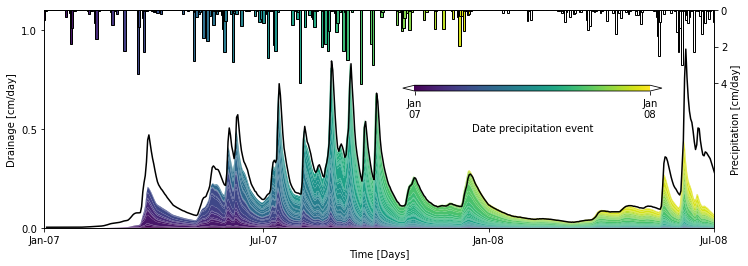

In [8]:
fig, ax1 = plt.subplots(1,1, figsize=(12,4), sharex=True)
import copy
cmap = copy.copy(mpl.cm.get_cmap("viridis"))
cmap.set_under('w')
cmap.set_over("w")
a = cmap(np.linspace(0, 1, 365))

# Plot the recharge and water age
df.plot(kind="area", ax=ax1, legend=False, linewidth=0, rasterized=True,
        color=a[df.columns.astype(float).astype(int)])
q.plot(ax=ax1, color="k")
ax1.set_xlim(0)
ax1.set_ylim(0, 1.1)
ax1.set_yticks([0, 0.5, 1])
plt.xlabel("Time [Days]")
plt.ylabel("Drainage [cm/day]")

# Plot the Precipitation data
ax2 = ax1.twinx()
atm.Prec.iloc[:365].plot.bar(ax=ax2, color=a, edgecolor="k", width=2)
ax2.bar(atm.Prec.iloc[365:].index, atm.Prec.iloc[365:], color="w", edgecolor="k", width=1.5)
ax2.set_ylabel("Precipitation [cm/day]")
ax2.set_ylim(12, 0)
ax2.set_yticks([0, 2, 4])
ax2.set_xlim(0, 550)
plt.xticks([0, 180, 365, 550], ["Jan-07", "Jul-07", "Jan-08", "Jul-08"])

# Plot Colorbar
norm  = mpl.colors.Normalize(vmin=0, vmax=365)
axl = fig.add_axes([0.54, 0.60, 0.3, 0.02])
cb1 = mpl.colorbar.ColorbarBase(axl, cmap=cmap, norm=norm, orientation='horizontal', extend="both", 
                                ticks=[0,365], label="Date precipitation event")
cb1.ax.set_xticklabels(["Jan\n07", "Jan\n08"]);

plt.savefig("../figures/figure_3.pdf", bbox_inches="tight", dpi=300)

### 8. Make a plot of the Travel Time Distributions

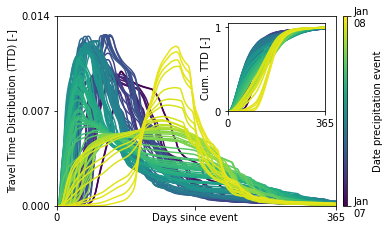

In [9]:
fig, ax = plt.subplots(1,1, figsize=(5, 3.5))

left, bottom, width, height = [0.6, 0.5, 0.27, 0.35]
ax2 = fig.add_axes([left, bottom, width, height])

for i in df2.columns:
    d = df2.loc[i:, i]
    d = d / d.cumsum().iloc[-1]
    d.index = range(len(d.index))
    d.plot(color=[a[i]], ax=ax)
    
    d = d.cumsum()/d.cumsum().iloc[-1]
    d.plot(color=[a[i]], ax=ax2)

ax.set_xticks([0, 180, 365])
ax.set_xticklabels(["0", "Days since event", "365"])
ax.set_xlim(0, 365)
ax.set_ylim(0, 0.014);
ax.set_yticks([0, 0.007, 0.014])
ax.set_ylabel("Travel Time Distribution (TTD) [-]")

ax2.set_xlim(0, 365)
ax2.set_ylim(0);
ax2.set_xticks([0, 365])
ax2.set_xticklabels(["0", "365"])
ax2.set_yticks([0, 1])
ax2.set_ylabel("Cum. TTD [-]")

# Plot Colorbar
axl = fig.add_axes([0.92, 0.125, 0.01, 0.755])
norm  = mpl.colors.Normalize(vmin=0, vmax=365)
cb1 = mpl.colorbar.ColorbarBase(axl, cmap=cmap, norm=norm, orientation='vertical',
                                ticks=[0,365], label="Date precipitation event")
cb1.ax.set_yticklabels(["Jan\n07", "Jan\n08"]);

plt.savefig("../figures/figure_2.pdf", bbox_inches="tight")